# Basic workflow example

In [1]:
import numpy as np
import nichepca as npc
import scipy
import scanpy as sc
from sklearn.cluster import KMeans
import networkx as nx
import matplotlib.pyplot as plt
import torch_geometric as pyg

In [2]:
def generate_dummy_adata(n_cells=100, n_genes=50, n_samples=2, seed=0):  # noqa
    random_state = np.random.RandomState(seed)

    X = random_state.randint(0, 400, size=(n_cells, n_genes))
    mask = random_state.rand(*X.shape) < 0.5
    X[mask] = 0
    X = scipy.sparse.csr_matrix(X)

    adata = sc.AnnData(X)

    # add random spatial coords in the unit square
    coords = random_state.rand(n_cells, 2)
    adata.obsm["spatial"] = coords

    # Partition the spatial coordinates into approximately equal parts
    kmeans = KMeans(n_clusters=n_samples, random_state=seed, n_init="auto")
    samples = kmeans.fit_predict(coords)
    adata.obs["sample"] = [str(s) for s in samples]

    return adata

## Run NichePCA (without harmony)

### Load data

In [3]:
adata = generate_dummy_adata(n_cells=50)

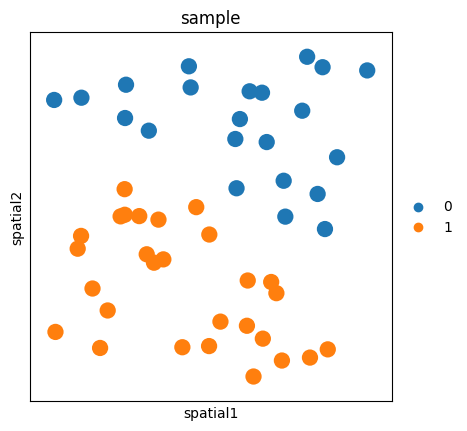

In [4]:
sc.pl.spatial(adata, color="sample", spot_size=0.05)

### Preprocessing

In [5]:
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.filter_cells(adata, min_genes=5)

### Calculate embeddings

In [6]:
npc.wf.run_nichepca(adata, knn=5)

----------- Graph Stats -----------
Number of nodes: 50
Number of edges: 362
Average in-degree: 7.239999771118164
Average out-degree: 7.239999771118164
Contains self-loops: True
Is undirected: True


### Cluster

In [7]:
sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution=0.5)

/tmp/ipykernel_1603211/1162026839.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


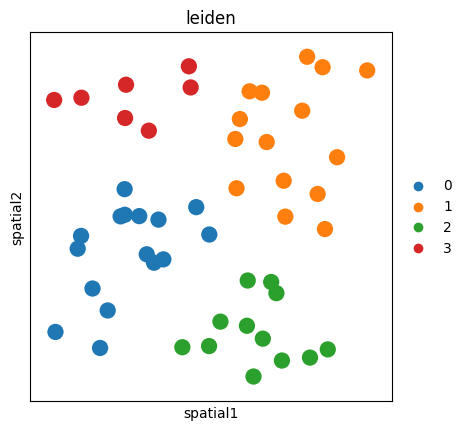

In [8]:
sc.pl.spatial(adata, color="leiden", spot_size=0.05)

## Run NichePCA (with harmony)

In [9]:
adata = generate_dummy_adata(n_cells=50)

### Preprocessing

In [10]:
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.filter_cells(adata, min_genes=5)

### Calculate embeddings

In [11]:
npc.wf.run_nichepca(adata, knn=5, sample_key="sample", verbose=False)

  0%|          | 0/2 [00:00<?, ?it/s]

2024-07-24 10:40:37,520 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-07-24 10:40:37,530 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-07-24 10:40:37,531 - harmonypy - INFO - Iteration 1 of 50
2024-07-24 10:40:37,547 - harmonypy - INFO - Iteration 2 of 50
2024-07-24 10:40:37,557 - harmonypy - INFO - Iteration 3 of 50
2024-07-24 10:40:37,570 - harmonypy - INFO - Converged after 3 iterations


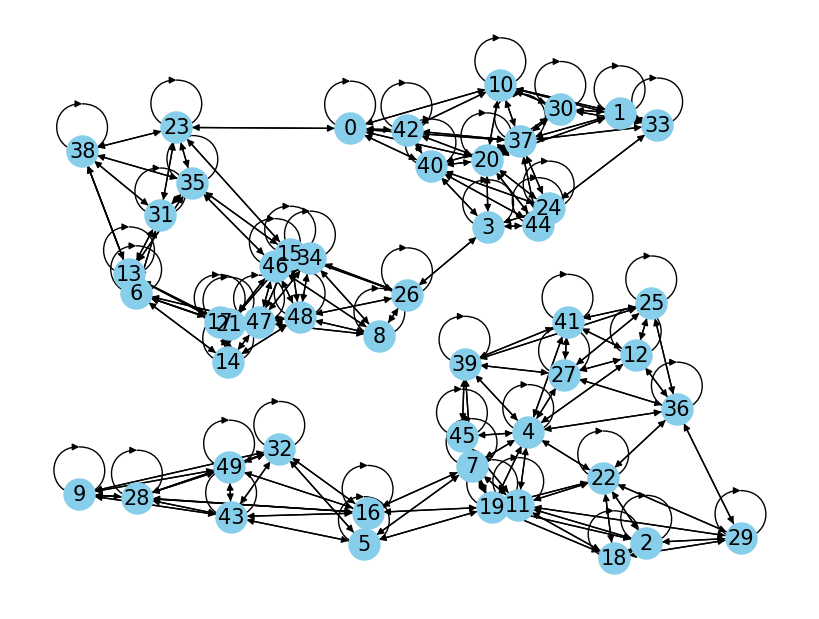

In [12]:
edge_index = npc.utils.to_torch(adata.uns["graph"]["edge_index"])
coords = npc.utils.to_torch(adata.obsm["spatial"])

# Create a PyTorch Geometric data object
data = pyg.data.Data(edge_index=edge_index, pos=coords)

# Convert to NetworkX graph
G = pyg.utils.to_networkx(data, node_attrs=["pos"])

# Extract positions
pos = {i: (data.pos[i][0].item(), data.pos[i][1].item()) for i in range(data.num_nodes)}

# Plot using NetworkX and matplotlib
plt.figure(figsize=(8, 6))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=500,
    node_color="skyblue",
    font_size=15,
    font_color="black",
)
plt.show()

### Cluster

In [13]:
sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution=0.5)

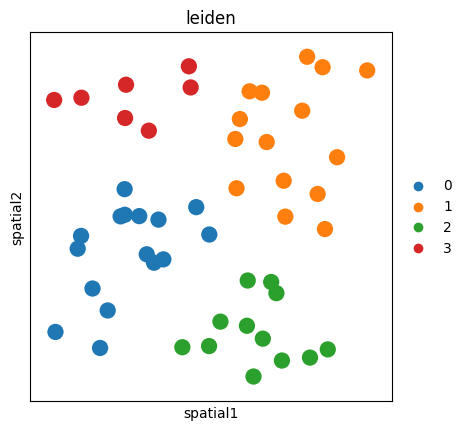

In [14]:
sc.pl.spatial(adata, color="leiden", spot_size=0.05)